In [27]:
## custom
from utils import utils, vis
from utils import poly_point_isect as bo   ##bentley-ottmann sweep line

import criteria as C
import quality as Q


## third party
import networkx as nx

from PIL import Image
from natsort import natsorted


## sys
import random
import time
from glob import glob
import math
from collections import defaultdict

## numeric
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F

## vis
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits import mplot3d
from matplotlib import collections  as mc
from mpl_toolkits.mplot3d.art3d import Line3DCollection

## notebook
from IPython import display
from IPython.display import clear_output
from tqdm.notebook import tqdm

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = 'cpu'
plt.style.use('ggplot')
plt.style.use('seaborn-colorblind')


In [28]:
import scipy.io as io


def load_spx_teaser():
    return load_node_link_txt('./graphs/spx_teaser.txt')
    
    
def load_node_link_txt(fn):
    def skip_nodes(f,n):
        for _ in range(n):
            f.readline()
#     def read_nodes(f, n):
#         nodes_init = []
#         for _ in range(n):
#             xy = f.readline().strip().split()
#             x,y = float(xy[0]), float(xy[1])
#             nodes_init.append((x,y))
#         return nodes_init
    G = nx.Graph()
    with open(fn) as f:
        n = int(f.readline().strip())
        skip_nodes(f, n)
#         nodes_init = read_nodes(f, n)
        G.add_nodes_from(range(n))
        for e in f:
            e = e.strip().split()
            e = int(e[0]), int(e[1])
            G.add_edge(*e)
    return G



## credit:
## https://github.com/jxz12/s_gd2/blob/master/jupyter/main.ipynb

# load the data from the SuiteSparse Matrix Collection format
# https://www.cise.ufl.edu/research/sparse/matrices/


def load_mat(fn='graphs/SuiteSparse Matrix Collection/grid1_dual.mat'):
    mat_data = io.loadmat(fn)
    adj = mat_data['Problem']['A'][0][0]
    G = nx.convert_matrix.from_numpy_matrix(adj.toarray())
    return G



## Optimize via Stochastic Gradient Descent (SGD)

## test runtime

In [2]:
# delete old
# !rm -r figures
!mkdir figures

mkdir: cannot create directory ‘figures’: File exists


In [4]:
# G = nx.Graph()
# G.add_nodes_from([0,1,2,3])
# G.add_edges_from([(0,1),(2,3)])

# print(f'of {len(G)} nodes')
# maxDegree = max(dict(G.degree).values())
# print('Calculating all pairs shortest path', end='...')

# D, k2i = utils.dict2tensor(dict(nx.all_pairs_shortest_path_length(G)))
# adj,_ = utils.dict2tensor(dict(G.adjacency()), fill=1, device=device)
# i2k = {i:k for k,i in k2i.items()}


# W = 1/(D**2+np.eye(len(G)))
# truth = adj + torch.eye(adj.shape[0], device=device)
# print('done')


# ##training
# pos = torch.tensor([[-1.0,-1],[1,1],[2,0],[0,1]])
# # pos = torch.randn(len(G.nodes), 2, device=device)

# pos.requires_grad_(True)

# w,b = crossings(pos, G, k2i, reg_coef=2, niter=200, sampleSize=10, )
# x,y = torch.meshgrid(torch.linspace(-5,5,20),torch.linspace(-5,5,20))
# xy = torch.stack([x.reshape(-1), y.reshape(-1)], -1)
# pred = (xy @ w.detach() + b.detach()).view(20,20)

# plt.contourf(x,y,pred, levels=np.linspace(-5,5,21), cmap='coolwarm')
# plt.contour(x,y,pred, levels=[-1,0,1])

# pos_numpy = pos.detach().cpu().numpy()
# pos_i = {k: pos_numpy[k2i[k], :2] for k in G.nodes}
# nx.draw_networkx(G, pos_i)

In [100]:
import scipy.sparse.csgraph as csgraph

G = nx.grid_2d_graph(180,360)
adj = 
d = csgraph.shortest_path(graph, directed=False, unweighted=True)


In [99]:
%%time


import importlib
importlib.reload(C)
importlib.reload(Q)
importlib.reload(utils)
importlib.reload(vis)


runtime = []

niter = int(1e5)

shouldVis = True
visIter = 500

shouldSnap = True
snapIter = 5

gClamp = 100
minLR = 1e-5
maxSampleSize = 128


totalTime = 0

print('generating graph', end=' ')
G = nx.grid_2d_graph(180,360)
# G = nx.hypercube_graph(3)
# G = nx.balanced_tree(2,4)
# G = load_spx_teaser()
# G = nx.karate_club_graph()


# graph_name = 'grid1'
# graph_name = 'grid1_dual'
# graph_name = 'odepa400'
# graph_name = 'netz4504_dual'
# graph_name = 'L'
# -----
# graph_name = 'netz4504'
# graph_name = 'qh882'
# mat_dir = 'graphs/SuiteSparse Matrix Collection'
# G = load_mat(f'{mat_dir}/{graph_name}.mat')


# G = nx.Graph()
# G.add_nodes_from([0,1,2,3])
# G.add_edges_from([(0,1),(2,3)])




print(f'of {len(G)} nodes')
maxDegree = max(dict(G.degree).values())
print('Calculating all pairs shortest path', end='...')
t0 = time.time()
D, k2i = utils.dict2tensor(dict(nx.all_pairs_shortest_path_length(G)))
adj,_ = utils.dict2tensor(dict(G.adjacency()), fill=1, device=device)
i2k = {i:k for k,i in k2i.items()}
edge_indices = [(k2i[e0], k2i[e1]) for e0,e1 in G.edges]
node_indices = range(len(G))
node_index_pairs = np.c_[
    np.repeat(node_indices, len(G)),
    np.tile(node_indices, len(G))
]
node_index_pairs_start = 0
np.random.shuffle(node_index_pairs)


    
dt = time.time() - t0
totalTime += dt

W = 1/(D**2+0.5)
truth = adj + torch.eye(adj.shape[0], device=device)
print('done')


##training
#     pos = torch.rand(len(G.nodes), 2, device=device)*2-1
pos = torch.randn(len(G.nodes), 2, device=device)
pos.requires_grad_(True)


##LOAD prev layout
# G_ = nx.read_gpickle(glob(f'layouts/balanced_tree_{2}_{7}-stress-*.gpickle')[0])
# pos = {k2i[k]: G_.nodes[k]['pos'] for k in G_.nodes}
# pos = torch.stack([torch.from_numpy(pos[i]) for i in range(len(pos))])
# pos = pos.requires_grad_(True)


# optimizer = optim.SGD([pos], lr=5, momentum=0.8, nesterov=True)
optimizer = optim.RMSprop([pos], lr=0.1)
patience = np.ceil(np.log2(len(G)))*50
# scheduler = None
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.7, patience=patience, 
                                                 min_lr=minLR, verbose=True)

iterBar = tqdm(range(niter))
lossCurve = []
sampleSize = min(len(G), maxSampleSize)
degrees = adj.sum(1).numpy().astype(np.int64)
xPath = []

qualityMeasureInterval = max(1, niter // 30)
qualityMeasureCurves = defaultdict(list)
activeQualityMeasures = [
    'stress',
#     'edge_uniformity',
#     'neighborhood_preservation',
#     'crossings',
    
#     'crossing_angle_maximization',
    'aspect_ratio',
#     'angular_resolution',
#     'vertex_resolution',
#     'gabriel',
    
]

for i in iterBar:
    t0 = time.time()
    if node_index_pairs_start >= len(G)**2:
        np.random.shuffle(node_index_pairs)
        node_index_pairs_start = 0
    ## optimization
    optimizer.zero_grad()
#     loss = C.stress(pos, D, W, sampleSize)
    loss = (
        +0.01*C.stress(pos, D, W, samples=node_index_pairs[node_index_pairs_start:node_index_pairs_start+sampleSize])
#         +0.5*C.edge_uniformity(pos, G, k2i, sampleSize-1)
#         +0.1*C.angular_resolution(pos, G, k2i, sampleSize=sampleSize//maxDegree)
#         + 10*C.aspect_ratio(pos, sampleSize)
#         C.crossing_angle_maximization(pos, G, k2i, i2k, sampleSize=10, sampleOn='crossings') ## slow for large sample size
#     +0.001*C.vertex_resolution(pos, sampleSize, target=1/len(G)**0.5)
#     + 0.1*C.gabriel(pos, G, k2i, sampleSize=int(sampleSize**0.5))
#         +1*C.crossings(pos, G, k2i, reg_coef=0.01, niter=20, sampleSize=4, sampleOn='crossings')
#         +C.crossings(pos, G, k2i, reg_coef=0.01, niter=20, sampleSize=20, sampleOn='edges')
#         C.neighborhood_preseration(pos, G, adj, k2i, i2k, n_roots=2, depth_limit=2)
    )
    loss.backward()
    pos.grad.clamp_(-gClamp, gClamp)
    optimizer.step()
    
    node_index_pairs_start+=sampleSize
    
    ## debug info
    dt = time.time() - t0
    totalTime += dt
    if loss.isnan():
        raise Exception('loss is nan')
        break
    if pos.isnan().any():
        raise Exception('pos is nan')
        break
    if i % int(niter/100) == int(niter/100)-1:
        iterBar.set_postfix({'loss': loss.item(), })    
    if len(lossCurve) > 0:
        lossCurve.append(0.9*lossCurve[-1] + 0.1*loss.item())
    else:
        lossCurve.append(loss.item())
    if shouldSnap and i % snapIter == 0:
        x = pos.detach().cpu().numpy()
        xPath.append(x.copy())    
    
    
    ## quality measures
    if i % qualityMeasureInterval == qualityMeasureInterval-1:
        if 'stress' in activeQualityMeasures:
            qualityMeasureCurves['stress'].append(
                Q.stress(pos, D, W, None)
            )
        if 'edge_uniformity' in activeQualityMeasures:
            qualityMeasureCurves['edge_uniformity'].append(
                Q.edge_uniformity(pos, G, k2i)
            )
        if 'neighborhood_preservation' in activeQualityMeasures:
            qualityMeasureCurves['neighborhood_preservation'].append(
                Q.neighborhood_preservation(pos, G, adj, i2k)
            )
        if 'crossings' in activeQualityMeasures:
            qualityMeasureCurves['crossings'].append(
                Q.crossings(pos, edge_indices)
            )
        if 'crossing_angle_maximization' in activeQualityMeasures:
            qualityMeasureCurves['crossing_angle_maximization'].append(
                Q.crossing_angle_maximization(pos, G.edges, k2i)
            )
        if 'aspect_ratio' in activeQualityMeasures:
            qualityMeasureCurves['aspect_ratio'].append(
                Q.aspect_ratio(pos)
            )
        if 'angular_resolution' in activeQualityMeasures:
            qualityMeasureCurves['angular_resolution'].append(
                Q.angular_resolution(pos, G, k2i)
            )
            
        if 'vertex_resolution' in activeQualityMeasures:
            qualityMeasureCurves['vertex_resolution'].append(
                Q.vertex_resolution(pos, target=1/len(G)**0.5)
            )
        if 'gabriel' in activeQualityMeasures:
            qualityMeasureCurves['gabriel'].append(
                Q.gabriel(pos, G, k2i)
            )
        

    ##vis
    if shouldVis and i % visIter == visIter-1:
        x = pos.detach().cpu().numpy()
        pos_i = {k: x[k2i[k], :2] for k in G.nodes}
        display.clear_output(wait=True)
        vis.plot(G, pos_i, lossCurve, [], i, totalTime, node_size=6, edge=True, show=True, save=False)
    
        
    if scheduler is not None:
        scheduler.step(lossCurve[-1])
    

    #     if optimizer.param_groups[0]['lr'] <= minLR \
#     or pos.grad.max() < 1e-5*(pos[0,:].max()-pos[:,0].min()):
#         print('Done')
#         break

generating graph of 64800 nodes
Calculating all pairs shortest path...

KeyboardInterrupt: 

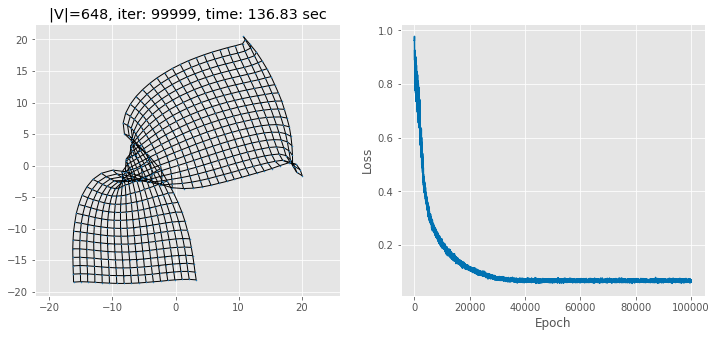

136.8334755897522

In [89]:
# show final result
x = pos.detach().cpu().numpy()
pos_i = {k: x[k2i[k], :2] for k in G.nodes}
vis.plot(G, pos_i, lossCurve, [], i, totalTime,  
         show=True, save=False, title=f'|V|={len(G)}, iter: {i}, time: {totalTime:.2f} sec')
totalTime

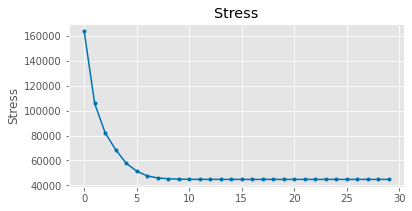

[163713.453125, 105721.078125, 82167.65625, 68662.140625, 57794.1015625, 51491.578125, 47646.86328125, 46016.703125, 45330.94921875, 44999.8203125, 44887.51953125, 44848.94921875, 44837.1484375, 44833.60546875, 44832.73828125, 44832.5859375, 44832.5546875, 44832.5546875, 44832.5546875, 44832.5546875, 44832.5546875, 44832.5546875, 44832.5546875, 44832.5546875, 44832.5546875, 44832.5546875, 44832.5546875, 44832.5546875, 44832.55859375, 44832.5546875]


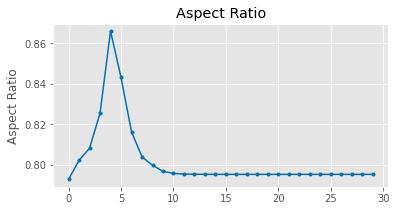

[0.7929164171218872, 0.8023068904876709, 0.8082447052001953, 0.8254688382148743, 0.8658812642097473, 0.8430684208869934, 0.8163591623306274, 0.8039941191673279, 0.7998865842819214, 0.7968599796295166, 0.7958443760871887, 0.7955716252326965, 0.7954198122024536, 0.7954039573669434, 0.7953923344612122, 0.7953903079032898, 0.7953897714614868, 0.7953898310661316, 0.7953898310661316, 0.7953898310661316, 0.7953898310661316, 0.7953898310661316, 0.7953898310661316, 0.7953898310661316, 0.7953898310661316, 0.7953898310661316, 0.7953898310661316, 0.7953898310661316, 0.7953898310661316, 0.7953898310661316]


In [96]:
for q in activeQualityMeasures:
    plt.figure(figsize=[6,3])
    plt.plot(qualityMeasureCurves[q],'.-')
    plt.ylabel(' '.join(s.capitalize() for s in q.split('_')))
    plt.title(' '.join(s.capitalize() for s in q.split('_')))
    plt.show()
    print(qualityMeasureCurves[q])

In [339]:
1/len(G)**0.5

0.1796053020267749

In [ ]:
# fig, ax = plt.subplots()

# nx.draw_networkx(G, pos_i, ax=ax)
# ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)


## Animation

In [ ]:
# from matplotlib.animation import FuncAnimation
# from IPython.display import HTML

# if type(xPath) == list:
#     xPath = np.stack(xPath)
    
# padding = 0.1

# fig, ax = plt.subplots()
# scatter = plt.scatter([0], [0], s=10)
# lc = mc.LineCollection([], linewidths=1)
# ax.add_collection(lc)

# xlim = [np.min(xPath[:,:,0]),np.max(xPath[:,:,0])]
# ylim = [np.min(xPath[:,:,1]),np.max(xPath[:,:,1])]
# xlim = [xlim[0]-padding*(xlim[1]-xlim[0]), xlim[1]+padding*(xlim[1]-xlim[0])]
# ylim = [ylim[0]-padding*(ylim[1]-ylim[0]), ylim[1]+padding*(ylim[1]-ylim[0])]
# ax.set_xlim(xlim)
# ax.set_ylim(ylim)
    
# def init():
#     return scatter,lc

# def update(frame):
#     xy = xPath[frame]
#     scatter.set_offsets(xy)
#     segs = [[xy[k2i[k0]], xy[k2i[k1]]] for k0,k1 in G.edges]           
#     lc.set_segments(segs)
#     return scatter,lc

# anim = FuncAnimation(
#     fig, 
#     update, 
#     frames=range(0,len(xPath),1),
#     init_func=init, 
#     interval=1000.0/20,
#     blit=True)

# HTML(anim.to_jshtml())

In [ ]:
# x = pos.detach().cpu().numpy()
# pos_i = {k: x[k2i[k], :2] for k in G.nodes}
# vis.plot(G, pos_i, lossHistory, [], i, totalTime, show=True, save=True)

## animation

In [ ]:
# # Create a gif from images in fig/
# # 
# frames = []
# imgs = natsorted(glob('fig/*.png'))

# for img in imgs:
#     new_frame = Image.open(img)
#     frames.append(new_frame)

# # Save into a GIF file that loops forever
# frames[0].save(f'anim-{int(time.time())}.gif', format='GIF',
#                append_images=frames[1:],
#                save_all=True,
#                duration=100, loop=0)